In [ ]:
import os
import fitsio
import desimodel
import astropy
import pandas                as     pd
import pylab                 as     pl
import numpy                 as     np
import astropy.io.fits       as     fits
import matplotlib.pyplot     as     plt

from   datetime              import datetime
from   astropy.table         import Table, vstack, join
from   astropy.coordinates   import Angle, SkyCoord
from   astropy               import units as u

from   desimodel.footprint   import is_point_in_desi
from   desimodel             import io
from   desitarget.geomask    import circles
from   desitarget.targetmask import desi_mask, obsconditions
from   astropy.coordinates   import SkyCoord
from   astropy.table         import Table
from   pathlib               import Path
from   desimodel.focalplane  import get_tile_radius_deg

In [2]:
np.random.seed(seed=314)

Potential addition: 'Stars were removed from the sample used to compute the number counts using SExtractor’s CLASS_STAR parameter with a threshold of 0.85'

In [3]:
def get_hildebrandt(field='D2'):
    # SXDS:  (02:18:00.00, −05:00:00.00), D1 encompassed by W1.  
    return  Table.read('/global/cscratch1/sd/mjwilson/DESILBG/Hildebrandt/{}.cat'.format(field))

In [4]:
def get_goldrush():
    # https://arxiv.org/pdf/1704.06004.pdf    
    return Table.read('/global/homes/m/mjwilson/DESILBG/target/proposals/goldrush/goldrush_mizukizs.fits')

In [5]:
def get_laes():
    # https://arxiv.org/pdf/0801.4017.pdf
    dat   = pd.read_csv('/global/homes/m/mjwilson/DESILBG/target/proposals/sxds_laes.txt', sep='\s+', comment='#')
    
    dat.drop(dat.columns[list(np.arange(7, 20, 1))], axis=1, inplace=True)
    
    dat.columns = ['Row', 'Name', 'RA', 'DEC', 'None', 'Velocity', 'Redshift']
    dat['RA']   = [Angle(x).deg for x in dat['RA']]
    dat['DEC']  = [Angle(x[:-1] + '.0s').deg for x in dat['DEC']]
    
    return  dat

In [6]:
def get_vvds():
    # https://cesam.lam.fr/vvds/vvds_download.php
    dat = pd.read_csv('/global/cscratch1/sd/mjwilson/VVDS/cesam_vvds_spF02_DEEP_Full.txt', sep='\s+')

    # Cut.
    dat = dat[dat['Z'] < 9.0]
    
    return dat

In [7]:
def get_splash():
    dat = Table.read('/global/cscratch1/sd/mjwilson/SPLASH/SPLASH_SXDF_Mehta+_v1.6.fits')
    
    return dat

In [17]:
def get_clauds(imaging_bit=1, field='COSMOS', release='February2021'):
    fields           = ['COSMOS', 'DEEP_2', 'ELAIS', 'XMM_LSS']
    clauds           = {}
        
    assert field in fields
        
    areas            = {}
    areas['COSMOS']  = {'u': 4.41, 'uS': 4.20, 'g': 7.84,  'r': 7.84,  'i': 7.84,  'z': 7.84,  'y': 7.84}
    areas['XMM-LSS'] = {'u': 0.00, 'uS': 6.80, 'g': 6.38,  'r': 6.38,  'i': 6.38,  'z': 6.38,  'y': 6.38}
    areas['DEEP2-3'] = {'u': 3.70, 'uS': 0.00, 'g': 6.11,  'r': 6.11,  'i': 6.11,  'z': 6.11,  'y': 6.11}
    areas['ELAIS-N'] = {'u': 6.49, 'uS': 0.00, 'g': 10.68, 'r': 10.68, 'i': 10.68, 'z': 10.68, 'y': 10.68}

    for key in areas.keys():
        if imaging_bit == 1:
            del areas[key]['uS']
    
        elif imaging_bit == 2:
            del areas[key]['u']

    if release == 'October2020':
        raise NotImplementedError()
        
    else:   
        clauds[field] = Table.read('/global/cscratch1/sd/mjwilson/clauds/{}/{}_v9_v210212.fits'.format(release, field))
    
    # Bright star mask & has newer u band data: [HSC, u, Us, J, VirCAM, UDEEP] for FLAG_FIELD_BINARY (imaging_bit). 
    clauds[field] = clauds[field][(clauds[field]['MASK'] == 0) & clauds[field]['FLAG_FIELD_BINARY'][:,imaging_bit] == True]

    # Randomise the rows for security. 
    indices       = np.arange(len(clauds[field]))
    randomised    = np.random.choice(indices, size=len(indices), replace=False)
    
    return  clauds[field][randomised], areas[field]

In [9]:
def get_cfhtls_wide():
    # https://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/megapipe/cfhtls/uc.html; I-band detected. 
    # u-band limit of 25.2 in the wide field.
    filename = '/global/cscratch1/sd/mjwilson/CFHTLS/W.I.con.cat'     
    
    names    = []

    with open(filename, 'r') as fh:
      for curline in fh:
         if curline.startswith("#"):
              words = curline.split()
              names.append(words[2])

         else:
            break
    
    fh.close()
    
    dat   = pd.read_csv(filename, sep='\s+', comment='#', names=names)
                        
    return  dat

In [10]:
tile_radius = get_tile_radius_deg()
tiles       = Table(io.load_tiles())

In [13]:
# hiz  = laigle()

In [14]:
# kids = get_kids()

In [15]:
# splash = get_splash()

In [16]:
# splash_zspec = splash[splash['ZSPEC'] > 0.]

In [11]:
# hilde  = get_hildebrandt()

In [12]:
# grush  = get_goldrush()

In [13]:
# laes   = get_laes()

In [17]:
# cfhtls = get_cfhtls_wide()

In [14]:
# vvds = get_vvds()

In [18]:
clauds, area = get_clauds(imaging_bit=1, field='COSMOS')

In [19]:
# Old length: 2582606
clauds

ID,RA,DEC,TRACT,PATCH,MASK,FLAG_FIELD,FLAG_FIELD_BINARY [5],A_WORLD,B_WORLD,KRON_RADIUS,THETA_WORLD,ELONGATION,ELLIPTICITY,EB_V,FWHM_WORLD_HSC_I,MU_MAX_HSC_I,CLASS_STAR_HSC_I,FLUX_RADIUS_0.25_HSC_I,FLUX_RADIUS_0.5_HSC_I,FLUX_RADIUS_0.75_HSC_I,FUV,NUV,u,uS,g,r,i,z,y,Yv,J,H,Ks,FUV_err,NUV_err,u_err,uS_err,g_err,r_err,i_err,z_err,y_err,Yv_err,J_err,H_err,Ks_err,MAG_APER_2s_u,MAG_APER_2s_uS,MAG_APER_2s_g,MAG_APER_2s_r,MAG_APER_2s_i,MAG_APER_2s_z,MAG_APER_2s_y,MAG_APER_2s_Yv,MAG_APER_2s_J,MAG_APER_2s_H,MAG_APER_2s_Ks,MAGERR_APER_2s_u,MAGERR_APER_2s_uS,MAGERR_APER_2s_g,MAGERR_APER_2s_r,MAGERR_APER_2s_i,MAGERR_APER_2s_z,MAGERR_APER_2s_y,MAGERR_APER_2s_Yv,MAGERR_APER_2s_J,MAGERR_APER_2s_H,MAGERR_APER_2s_Ks,MAG_APER_3s_u,MAG_APER_3s_uS,MAG_APER_3s_g,MAG_APER_3s_r,MAG_APER_3s_i,MAG_APER_3s_z,MAG_APER_3s_y,MAG_APER_3s_Yv,MAG_APER_3s_J,MAG_APER_3s_H,MAG_APER_3s_Ks,MAGERR_APER_3s_u,MAGERR_APER_3s_uS,MAGERR_APER_3s_g,MAGERR_APER_3s_r,MAGERR_APER_3s_i,MAGERR_APER_3s_z,MAGERR_APER_3s_y,MAGERR_APER_3s_Yv,MAGERR_APER_3s_J,MAGERR_APER_3s_H,MAGERR_APER_3s_Ks,OFFSET_MAG_2s,OFFSET_MAG_3s,CONTEXT,MAG_ABS_FUV,MAG_ABS_NUV,MAG_ABS_u,MAG_ABS_uS,MAG_ABS_g,MAG_ABS_r,MAG_ABS_i,MAG_ABS_z,MAG_ABS_y,MAG_ABS_Yv,MAG_ABS_J,MAG_ABS_H,MAG_ABS_Ks,Z_SPEC,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,NBAND_USED,CHI_BEST,CHI_STAR,CHI_QSO,MOD_BEST,MOD_STAR,MOD_QSO,Z_ML,Z_ML68_LOW,Z_ML68_HIGH,Z_SEC,Z_QSO,Z_BC03,ZPHOT,MOD_BEST_BC03,AGE_BEST,EBV_BEST,EXTLAW_BEST,AGE_MED,MASS_MED,MASS_BEST,MASS_INF,MASS_SUP,SFR_MED,SFR_BEST,SFR_INF,SFR_SUP,SSFR_MED,SSFR_BEST,SSFR_INF,SSFR_SUP,LUM_NUV_BEST,LUM_R_BEST,LUM_K_BEST,OBJ_TYPE,COMPACT,STAR_FORMING,NrK,IRX_NrK,LIR_NrK,SFR_NrK
int64,float64,float64,int64,bytes3,int16,int16,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64
3154335,149.13232433290514,2.5546504606039897,9812,"2,6",0,7,True .. False,6.432973e-05,4.1858057e-05,4.0,65.04344,1.5367969,0.34929597,0.019528131582531447,0.00024061684,25.891245,0.356922,1.0085294,1.4280493,1.7852052,-99.0,-99.0,-99.094,28.809,29.315,27.493,26.726,27.176,27.869,-99.024,-99.017,-99.011,-99.007,-99.0,-99.0,-99.0,1.811,1.439,0.368,0.235,0.554,2.562,1000.0,1000.0,1000.0,1000.0,99.0,28.899778,29.386625,27.545229,26.76477,27.20536,27.893911,-99.0,-99.0,-99.0,-99.0,-99.0,1.8105469,1.4394531,0.36767578,0.23498535,0.5541992,2.5625,1000.0,1000.0,1000.0,1000.0,99.0,99.0,99.0,29.40419,26.695395,28.843664,99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,3.0585938,0.3310547,3.7519531,-99.0,1000.0,1000.0,1000.0,1000.0,0.0,-1.666145738744851,2046.0,-18.286,-17.828,-144.694,-144.851,-144.744,-145.078,-145.358,-145.578,-145.693,-145.729,-145.855,-146.046,-145.886,3.2816,3.2816,-99.0,-99.0,10,1.50695,1.32878,0.527892,7,96,18,-99.0,-99.0,-99.0,-99.0,3.36,3.2816,3.2816,7,180529000.0,0.4,1,499925000.0,9.67309,9.59731,8.88242,10.515,1.19656,1.46308,0.542404,1.98557,-8.47592,-8.13423,-8.90557,-7.99327,10.319,9.87009,8.84008,0.0,0,0,46.35665456424919,30.3961676564

In [20]:
print('Target density of clauds galaxies per sq. deg. is {:.2f}'.format(len(clauds) / area['u']))

Target density of clauds galaxies per sq. deg. is 625272.11


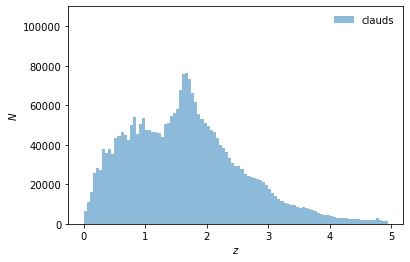

In [21]:
bins = np.arange(0.0, 5.0, 0.05)

pl.hist(clauds['Z_BEST'], bins=bins, alpha=0.5, label='clauds')

pl.ylim(0.0, 1.1e5)

pl.xlabel(r'$z$')
pl.ylabel(r'$N$')

pl.legend(frameon=False)

In [22]:
isin, indx = is_point_in_desi(tiles, clauds['RA'], clauds['DEC'], radius=None, return_tile_index=True)

In [23]:
tileids = np.unique(indx)

In [24]:
tileids

array([  828,  2826,  3754,  5656,  5752,  5753,  7750, 11747, 13744,
       13745])

In [25]:
# u-band imaging restricted.
cra      = np.median(clauds['RA'])
cdec     = np.median(clauds['DEC'])

trad     = tile_radius

In [26]:
# (10:00:59.50, 02:13:53.06)
hsc_cosmos = SkyCoord('10h00m59.5s', '+02d13m53.06s', frame='icrs')

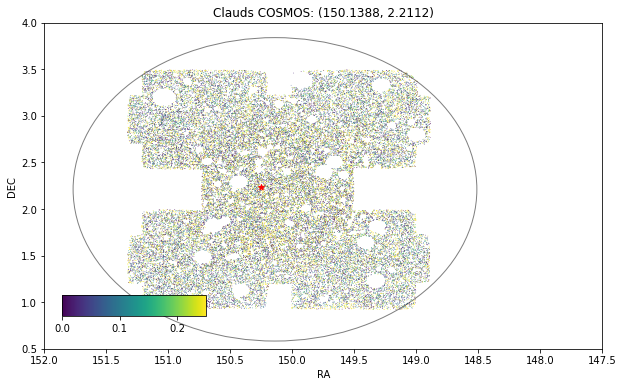

In [28]:
fig, ax  = plt.subplots(1, 1, figsize=(10, 6)) 
im       = pl.scatter(clauds['RA'][::50], clauds['DEC'][::50], c=clauds['u_err'][::50], marker='.', s=2, lw=0.0, vmin=0.0, vmax=.25)

pl.scatter(hsc_cosmos.ra.deg, hsc_cosmos.dec.deg, marker='*', c='r')

circles(cra, cdec, trad, c='k', fc="None", alpha=0.5)
        
ax.set_xlim(152., 147.5)
ax.set_ylim( 0.5,   4.0)

ax.set_xlabel('RA')
ax.set_ylabel('DEC')

cax      = fig.add_axes([0.15, 0.2, 0.2, 0.05])
fig.colorbar(im, cax=cax, orientation='horizontal')

ax.set_title('Clauds COSMOS: ({:.4f}, {:.4f})'.format(cra, cdec))

pl.savefig('clauds_field.pdf')

In [29]:
def liu_udrops(clauds, band='r', magmin=0.0, maglim=35.):
    '''
    u-drop color selection.
    '''

    # Check these targets have u band imaging available. 
    assert  np.all(clauds['FLAG_FIELD_BINARY'][:,1] == True)
    
    isin = clauds['g'] - clauds['r'] < 1.2
    
    isin = isin & (clauds['u'] - clauds['g'] > 0.88)
    isin = isin & (clauds['u'] - clauds['g'] > 1.99 * (clauds['g'] - clauds['r']) + 0.68)
    isin = isin & (clauds[band] < maglim)
    isin = isin & (clauds[band] > magmin)
    
    # Catch -99 for ill defined magnitudes
    isin = isin & (clauds['u'] > 0.0)
    isin = isin & (clauds['g'] > 0.0)
    
    return  isin

In [30]:
def hilde_usdrops(clauds, band='r', magmin=0.0, maglim=35.):
    '''
    uS-drop color selection.
    '''
    
    # Check these targets have uS band imaging available.
    assert  np.all(clauds['FLAG_FIELD_BINARY'][:,2] == True)
    
    isin = clauds['g'] - clauds['r'] < 1.2
    isin = isin & (clauds['uS'] - clauds['g'] > 0.90)
    isin = isin & (clauds['uS'] - clauds['g'] > 1.50 * (clauds['g'] - clauds['r']) + 0.75)
    isin = isin & (clauds[band] < maglim)
    isin = isin & (clauds[band] > magmin)
    
    return  isin

In [31]:
udrops    = clauds[liu_udrops(clauds)]

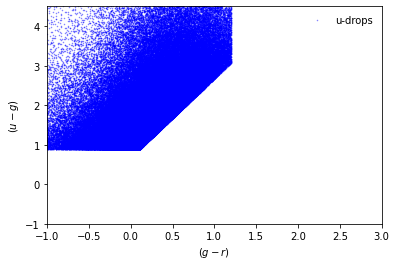

In [32]:
pl.plot(udrops['g'] - udrops['r'], udrops['u'] - udrops['g'], marker='.', c='b', lw=0.0, label='u-drops', alpha=0.5, markersize=1)

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(g-r)$')
pl.ylabel(r'$(u-g)$')

pl.legend(frameon=False)

pl.savefig('plots/Feb21/clauds-udrop-color-selection.pdf')

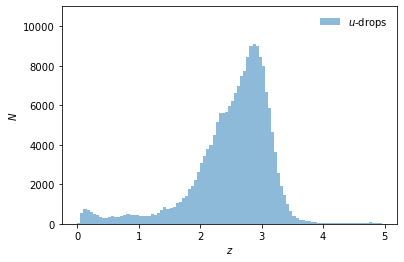

In [33]:
bins = np.arange(0.0, 5.0, 0.05)

pl.hist(udrops['Z_BEST'], bins=bins, alpha=0.5, label='$u$-drops')

pl.ylim(0.0, 1.1e4)

pl.xlabel(r'$z$')
pl.ylabel(r'$N$')

pl.legend(frameon=False)

In [38]:
zmax       = 1.5

interloper = udrops[udrops['Z_BEST'] < zmax]
highz      = udrops[udrops['Z_BEST'] > zmax]

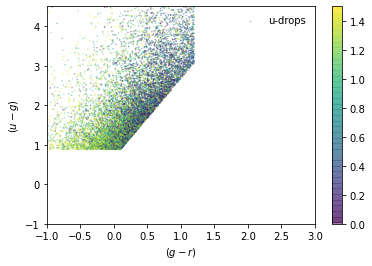

In [39]:
pl.scatter(interloper['g'] - interloper['r'], interloper['u'] - interloper['g'], marker='.', c=interloper['Z_BEST'], alpha=0.5, label='u-drops', vmin=0.0, vmax=zmax, s=1)

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(g-r)$')
pl.ylabel(r'$(u-g)$')

pl.colorbar()

pl.legend(frameon=False)

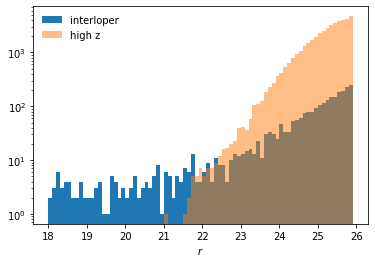

In [40]:
bins = np.arange(18., 26., 0.1)

pl.hist(interloper['r'], bins=bins, label='interloper')
pl.hist(     highz['r'], bins=bins, alpha=0.5, label='high z')

pl.yscale('log')
pl.xlabel(r'$r$')

pl.legend(frameon=False)

In [42]:
rlim_udrops = clauds[liu_udrops(clauds, band='r', magmin=19., maglim=26.)]

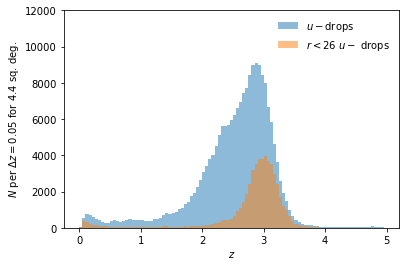

In [43]:
dz          = 0.05
bins        = np.arange(0.0, 5.0, dz)

pl.hist(udrops['Z_BEST'], bins=bins, alpha=0.5, label=r'$u-$drops')
pl.hist(rlim_udrops['Z_BEST'], bins=bins, alpha=0.5, label=r'$r<26$ $u-$ drops')

pl.ylim(0.0, 1.2e4)

pl.xlabel(r'$z$')
pl.ylabel(r'$N$ per $\Delta z={:.2f}$ for {:.1f} sq. deg.'.format(dz, area['u']))

pl.legend(frameon=False)

pl.savefig('plots/Feb21/clauds-udrop-redshift-distribution.pdf')

In [44]:
print('Target density of u-dropouts per sq. deg. is {:.2f}'.format(len(rlim_udrops) / area['u']))

Target density of u-dropouts per sq. deg. is 11691.16


In [46]:
print('u-dropout interloper percentage of {:.3f}'.format(100. * np.count_nonzero(rlim_udrops['ZPHOT'] < 1.5) / len(rlim_udrops)))

u-dropout interloper percentage of 5.429


In [47]:
def flatmagcat(maglimcat, band, maglim=26.01, debug=False):
    bins       = np.arange(20., maglim, 0.1)
    
    assert  maglimcat[band].max() <= maglim
    
    result     = np.histogram(maglimcat[band], bins=bins)

    cnts, bins = result[0], result[1]
    lims       = bins[:-1]
     
    cut        = cnts > 0.25 * np.median(cnts[cnts > 0])
    cutlim     = lims[cut][0]
        
    magsampling                    = cnts / cnts[cut][0]    
    magsampling[(magsampling < 1.) & (bins[:-1] < cutlim)] = 1.0
    
    if debug:
        print(magsampling)
    
    magsampling                    = 1. / magsampling
        
    magsampling                = np.concatenate((magsampling, np.array([0])))
        
    indx                       = np.digitize(maglimcat[band], bins)
    
    sampling                   = np.random.uniform(0.0, 1.0, len(maglimcat))
    
    maglimcat['ISIN']          = sampling < magsampling[indx]
        
    # In, residual.
    return  cutlim, maglimcat[maglimcat['ISIN']], maglimcat[~maglimcat['ISIN']]

In [48]:
def qa(tiers, band, area):
    upriority, cnts = np.unique(tiers['PRIORITY'].data, return_counts=True)

    for p, c in zip(upriority[::-1], cnts[::-1]):
        magmin      = tiers[tiers['PRIORITY'] == p][band].min()
        
        meanmag     = np.mean(tiers[tiers['PRIORITY'] == p][band])
        meanz       = np.mean(tiers[tiers['PRIORITY'] == p]['Z_BEST'])
        
        quarter     = np.percentile(tiers[tiers['PRIORITY'] == p]['Z_BEST'].compressed(), 25, axis=0)
        medianz     = np.median(tiers[tiers['PRIORITY'] == p]['Z_BEST'].compressed())
        tquarter    = np.percentile(tiers[tiers['PRIORITY'] == p]['Z_BEST'].compressed(), 75, axis=0)   
        
        loper_rate  = 100. * np.count_nonzero(tiers[tiers['PRIORITY'] == p]['Z_BEST'] < 1.5) / len(tiers[tiers['PRIORITY'] == p]) 
        
        print('{: 10d} \t {: .1f} per sq. deg. \t {:.2f} \t {:.2f} \t {:.2f} \t ({:.2f} \t {:.2f} \t {:.2f}) \t {:.2f}% z < 1.5 contamination'.format(p, c / area, magmin, meanmag, meanz, quarter, medianz, tquarter, loper_rate))

In [49]:
def reduce(start_id, inputcat, band, ttype, area, maglim=26.1, levels=10, max_inpriority=500, priority_shift=0, reprioritise=True, write=False, debug=False):
    bins = np.arange(18., maglim, 0.1)
    result = pl.hist(inputcat[band], bins=bins, alpha=0.3)
    reducecat = Table(inputcat, copy=True)

    tiers = Table()
    total =  0

    for i in np.arange(levels):    
        priority                = 1000 * (levels - i) + priority_shift
        
        cutlim, flat_drops, reducecat = flatmagcat(reducecat, band, debug=debug, maglim=maglim)
        
        flat_drops['PRIORITY'] = priority
                    
        tiers                   = vstack((tiers, flat_drops))
    
        total                  += len(flat_drops)
    
        string = '{:.1f} \t {} \t {:d}'.format(cutlim, len(np.unique(tiers['PRIORITY'].data)), np.count_nonzero(tiers['PRIORITY'] == priority))

        # Reshuffle such that there's a max of 1000 to a priority class.
        # Move remaining to a lower tier.
        if np.count_nonzero(tiers['PRIORITY'] == priority) > max_inpriority:
            is_priority        = tiers['PRIORITY'] == priority

            n_priority         = np.cumsum(is_priority)

            is_priority[n_priority < (1 + max_inpriority)] = False  
        
            string += '\tAdjusting {:d} entries.'.format(len(tiers['PRIORITY'][is_priority]))
        
            if reprioritise:
                tiers['PRIORITY'][is_priority] -= 1000
    
            else:
                tiers['PRIORITY'][is_priority]  = -tiers['PRIORITY'][is_priority] 
    
        print(string)
        print('{:.1f} \t {} \t {:d}\n'.format(cutlim, len(np.unique(tiers['PRIORITY'].data)), np.count_nonzero(tiers['PRIORITY'] == priority)))
    
        result = pl.hist(tiers[tiers['PRIORITY'] == priority][band], bins=bins, alpha=0.25, label='PRIORITY {}'.format(priority))
    
    print('\n-------------------------\n')
    print('{} \t {}'.format(total, len(inputcat)))

    pl.xlim(18., 26.1)

    pl.xlabel(r'${}$'.format(band))
    pl.ylabel(r'$N$')

    pl.yscale('log')

    pl.legend(frameon=False, ncol=2)
    pl.title(r'${}$-drop'.format(ttype))
    pl.savefig('plots/Feb21/clauds-{}drop-magnitude-distribution.pdf'.format(ttype))
    
    isin, indx            = is_point_in_desi(tiles, tiers['RA'], tiers['DEC'], radius=None, return_tile_index=True)

    tiers['TILEID']       = tiles['TILEID'][indx]
    
    tiers['SAMPLE']       = 'CLAUDS-{}'.format(ttype.upper())
    tiers['TARGETID']     = start_id + np.arange(len(tiers))
    tiers['SUBPRIORITY']  = np.random.uniform(0.0, 1.0, len(tiers))

    tiers['PMRA']         = np.zeros(len(tiers),   dtype='>f4')
    tiers['PMDEC']        = np.zeros(len(tiers),   dtype='>f4')

    tiers['REF_EPOCH']    = np.zeros(len(tiers),   dtype='>f4')
    tiers['OVERRIDE']     = np.zeros(len(tiers),   dtype='>f4')

    tiers.meta['EXTNAME'] = 'MTL'

    del tiers['ISIN']
    
    if write:
        Path('/global/cscratch1/sd/mjwilson/DESILBG/Feb21/targets/{}drops/'.format(ttype)).mkdir(parents=True, exist_ok=True)
        
        upriorities = np.unique(tiers['PRIORITY'])
        
        for up in upriorities:
            ptiers  = tiers[tiers['PRIORITY'] == up] 
            ptiers.write('/global/cscratch1/sd/mjwilson/DESILBG/Feb21/targets/{}drops/{}drops-{}.fits'.format(ttype, ttype, str(up).replace('-','m')), format='fits', overwrite=True)

    print('\n\n')
            
    qa(tiers, band, area)
        
    print('\n\n')
        
    return tiers

21.7 	 1 	 746	Adjusting 246 entries.
21.7 	 2 	 500

23.6 	 3 	 4480	Adjusting 3980 entries.
23.6 	 4 	 500

24.1 	 5 	 6761	Adjusting 6261 entries.
24.1 	 6 	 500

24.4 	 7 	 6734	Adjusting 6234 entries.
24.4 	 8 	 500

24.7 	 9 	 7521	Adjusting 7021 entries.
24.7 	 10 	 500

24.9 	 11 	 5573	Adjusting 5073 entries.
24.9 	 12 	 500

25.0 	 13 	 2956	Adjusting 2456 entries.
25.0 	 14 	 500

25.1 	 15 	 2243	Adjusting 1743 entries.
25.1 	 16 	 500

25.2 	 17 	 2228	Adjusting 1728 entries.
25.2 	 18 	 500

25.3 	 19 	 1649	Adjusting 1149 entries.
25.3 	 20 	 500

25.4 	 21 	 1042	Adjusting 542 entries.
25.4 	 22 	 500

25.5 	 23 	 880	Adjusting 380 entries.
25.5 	 24 	 500

25.6 	 25 	 738	Adjusting 238 entries.
25.6 	 26 	 500

25.7 	 27 	 757	Adjusting 257 entries.
25.7 	 28 	 500

25.7 	 29 	 262
25.7 	 29 	 262

25.8 	 30 	 736	Adjusting 236 entries.
25.8 	 31 	 500

25.8 	 32 	 213
25.8 	 32 	 213

25.8 	 33 	 130
25.8 	 33 	 130

25.9 	 34 	 700	Adjusting 200 entries.
25.9 	 35 	 

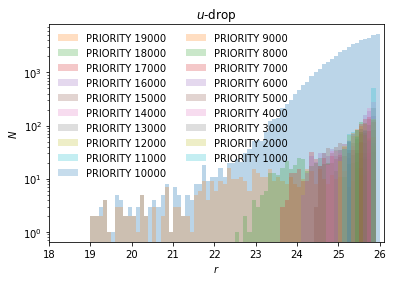

In [50]:
utiers = reduce(0, rlim_udrops, 'r', 'u', area['u'], reprioritise=False, maglim=26.01, levels=19, write=False)

# BX selection

In [51]:
def bx(cat, rmin=19., rmax=24.5):
    # https://arxiv.org/pdf/0903.3951.pdf    
    isin = np.ones(len(cat), dtype=bool)

    cat['u-g'] = cat['u'] - cat['g']
    cat['g-r'] = cat['g'] - cat['r']
    
    # LATIS, https://arxiv.org/pdf/2002.10676.pdf
    # 0.5 < u − g < 2.2 and −0.1 < g − r < 1.0 and u − g > 0.50 + 2.3(g − r − 0.35).
    isin &= cat['u-g'] >  0.0
    isin &= cat['u-g'] <  3.0
    isin &= cat['g-r'] > -0.5
    isin &= cat['g-r'] <  1.0
    isin &= cat['u-g'] >  1.0 + 2.3 * (cat['g-r'] - 0.35)

    # isin &= ((cat['g-r'] < 0.25) & (cat['u-g'] < 1.2)) | (cat['u-g'] >= 1.2)
    # isin &= ((cat['g-r'] < 0.15) & (cat['u-g'] < 1.0)) | (cat['u-g'] >= 1.0)
    
    isin  = isin & (cat['r'] > rmin)
    isin  = isin & (cat['r'] < rmax)
    isin  = isin & (~liu_udrops(cat, band='r', magmin=rmin, maglim=rmax))

    # Catch -99 for ill defined magnitudes
    isin = isin & (cat['u'] > 0.0)
    isin = isin & (cat['g'] > 0.0)
    
    return  isin

In [52]:
# not u-drops, by definition.
bx_clauds = clauds[bx(clauds, rmin=19., rmax=24.5)]

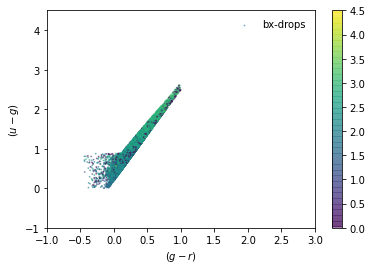

In [53]:
pl.scatter(bx_clauds['g'] - bx_clauds['r'], bx_clauds['u'] - bx_clauds['g'], marker='.', c=bx_clauds['Z_BEST'], alpha=0.5, label='bx-drops', vmin=0.0, vmax=4.5, s=3)

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(g-r)$')
pl.ylabel(r'$(u-g)$')

pl.colorbar()

pl.legend(frameon=False)

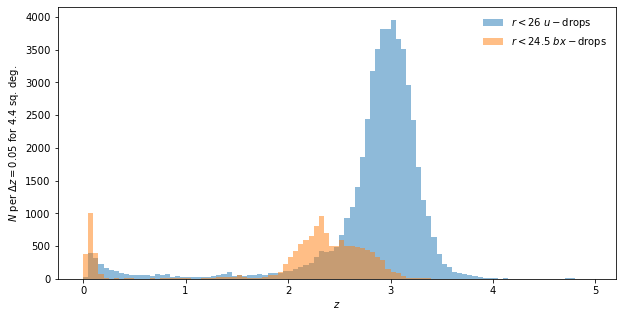

In [54]:
fig, axes = plt.subplots(1, 1, figsize=(10., 5.))
    
dz   = 0.05
bins = np.arange(0.0, 5.0, dz)

axes.hist(rlim_udrops['Z_BEST'], bins=bins, alpha=0.5, label=r'$r<26$ $u-$drops')
axes.hist(bx_clauds['Z_BEST'], bins=bins, alpha=0.5, label=r'$r<24.5$ $bx-$drops')

axes.set_xlabel(r'$z$')
axes.set_ylabel(r'$N$ per $\Delta z={:.2f}$ for {:.1f} sq. deg.'.format(dz, area['u']))

axes.legend(frameon=False)

In [55]:
print('Target density of bx-dropouts per sq. deg. is {:.2f}'.format(len(bx_clauds) / area['u']))

Target density of bx-dropouts per sq. deg. is 3018.14


In [56]:
bx_interlopers = bx_clauds[bx_clauds['ZPHOT'] < 0.1]

In [57]:
print('BX interloper percentage of {:.3f}'.format(100. * np.count_nonzero(bx_clauds['ZPHOT'] < 0.1) / len(bx_clauds)))

BX interloper percentage of 11.232


Text(0, 0.5, '$(u-g)$')

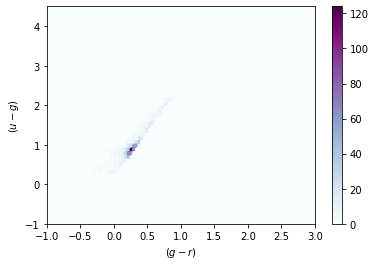

In [123]:
plt.hexbin(bx_interlopers['g'] - bx_interlopers['r'], bx_interlopers['u'] - bx_interlopers['g'], label='bx-drops', extent=[-1., 3., -1., 4.5], cmap='BuPu')
pl.colorbar()

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(g-r)$')
pl.ylabel(r'$(u-g)$')

In [58]:
start_id = len(utiers)
start_id

46349

20.0 	 1 	 1490	Adjusting 990 entries.
20.0 	 2 	 500

21.6 	 3 	 471
21.6 	 3 	 471

22.6 	 4 	 544	Adjusting 44 entries.
22.6 	 5 	 500

23.2 	 6 	 1261	Adjusting 761 entries.
23.2 	 7 	 500

23.4 	 8 	 1242	Adjusting 742 entries.
23.4 	 9 	 500

23.6 	 10 	 1455	Adjusting 955 entries.
23.6 	 11 	 500

23.7 	 12 	 1053	Adjusting 553 entries.
23.7 	 13 	 500

23.8 	 14 	 703	Adjusting 203 entries.
23.8 	 15 	 500

23.9 	 16 	 766	Adjusting 266 entries.
23.9 	 17 	 500

24.0 	 18 	 522	Adjusting 22 entries.
24.0 	 19 	 500

24.1 	 20 	 459
24.1 	 20 	 459

24.2 	 21 	 515	Adjusting 15 entries.
24.2 	 22 	 500

24.2 	 23 	 116
24.2 	 23 	 116

24.2 	 24 	 75
24.2 	 24 	 75

24.3 	 25 	 259
24.3 	 25 	 259

24.3 	 26 	 74
24.3 	 26 	 74


-------------------------

11005 	 13310



     19000 	  113.4 per sq. deg. 	 19.00 	 21.85 	 0.40 	 (0.07 	 0.10 	 2.27) 	 62.00% z < 1.5 contamination
     18000 	  106.8 per sq. deg. 	 20.06 	 22.81 	 0.40 	 (0.08 	 2.06 	 2.46) 	 42.68% z < 1.5 con

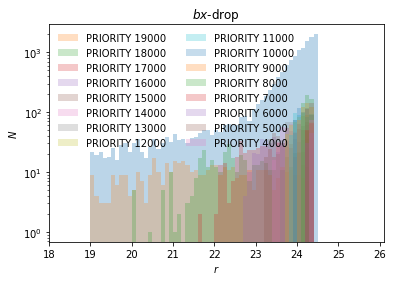

In [59]:
bxtiers = reduce(start_id, bx_clauds, 'r', 'bx', area['u'], levels=16, priority_shift=3000, maglim=24.51, reprioritise=False, debug=False, write=False)

In [60]:
bxtiers[bxtiers['PRIORITY'] >= 0]

ID,RA,DEC,TRACT,PATCH,MASK,FLAG_FIELD,FLAG_FIELD_BINARY [5],A_WORLD,B_WORLD,KRON_RADIUS,THETA_WORLD,ELONGATION,ELLIPTICITY,EB_V,FWHM_WORLD_HSC_I,MU_MAX_HSC_I,CLASS_STAR_HSC_I,FLUX_RADIUS_0.25_HSC_I,FLUX_RADIUS_0.5_HSC_I,FLUX_RADIUS_0.75_HSC_I,FUV,NUV,u,uS,g,r,i,z,y,Yv,J,H,Ks,FUV_err,NUV_err,u_err,uS_err,g_err,r_err,i_err,z_err,y_err,Yv_err,J_err,H_err,Ks_err,MAG_APER_2s_u,MAG_APER_2s_uS,MAG_APER_2s_g,MAG_APER_2s_r,MAG_APER_2s_i,MAG_APER_2s_z,MAG_APER_2s_y,MAG_APER_2s_Yv,MAG_APER_2s_J,MAG_APER_2s_H,MAG_APER_2s_Ks,MAGERR_APER_2s_u,MAGERR_APER_2s_uS,MAGERR_APER_2s_g,MAGERR_APER_2s_r,MAGERR_APER_2s_i,MAGERR_APER_2s_z,MAGERR_APER_2s_y,MAGERR_APER_2s_Yv,MAGERR_APER_2s_J,MAGERR_APER_2s_H,MAGERR_APER_2s_Ks,MAG_APER_3s_u,MAG_APER_3s_uS,MAG_APER_3s_g,MAG_APER_3s_r,MAG_APER_3s_i,MAG_APER_3s_z,MAG_APER_3s_y,MAG_APER_3s_Yv,MAG_APER_3s_J,MAG_APER_3s_H,MAG_APER_3s_Ks,MAGERR_APER_3s_u,MAGERR_APER_3s_uS,MAGERR_APER_3s_g,MAGERR_APER_3s_r,MAGERR_APER_3s_i,MAGERR_APER_3s_z,MAGERR_APER_3s_y,MAGERR_APER_3s_Yv,MAGERR_APER_3s_J,MAGERR_APER_3s_H,MAGERR_APER_3s_Ks,OFFSET_MAG_2s,OFFSET_MAG_3s,CONTEXT,MAG_ABS_FUV,MAG_ABS_NUV,MAG_ABS_u,MAG_ABS_uS,MAG_ABS_g,MAG_ABS_r,MAG_ABS_i,MAG_ABS_z,MAG_ABS_y,MAG_ABS_Yv,MAG_ABS_J,MAG_ABS_H,MAG_ABS_Ks,Z_SPEC,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,NBAND_USED,CHI_BEST,CHI_STAR,CHI_QSO,MOD_BEST,MOD_STAR,MOD_QSO,Z_ML,Z_ML68_LOW,Z_ML68_HIGH,Z_SEC,Z_QSO,Z_BC03,ZPHOT,MOD_BEST_BC03,AGE_BEST,EBV_BEST,EXTLAW_BEST,AGE_MED,MASS_MED,MASS_BEST,MASS_INF,MASS_SUP,SFR_MED,SFR_BEST,SFR_INF,SFR_SUP,SSFR_MED,SSFR_BEST,SSFR_INF,SSFR_SUP,LUM_NUV_BEST,LUM_R_BEST,LUM_K_BEST,OBJ_TYPE,COMPACT,STAR_FORMING,NrK,IRX_NrK,LIR_NrK,SFR_NrK,u-g,g-r,PRIORITY,TILEID,SAMPLE,TARGETID,SUBPRIORITY,PMRA,PMDEC,REF_EPOCH,OVERRIDE
int64,float64,float64,int64,bytes3,int16,int16,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,int64,int32,str9,int64,float64,float32,float32,float32,float32
2680362,150.5640898044576,1.060884778316955,9571,"7,6",0,3,True .. False,0.00015113335,0.00014769929,4.0,-56.539272,1.0232868,0.022756882,0.021017490578430307,0.00017296102,20.86546,0.9862529,0.8441919,1.2565919,1.6244657,-99.0,-99.0,22.547,22.353,21.699,21.428,21.303,21.244,21.293,-99.025,-99.018,-99.012,-99.008,-99.0,-99.0,0.002,0.016,0.002,0.002,0.002,0.003,0.007,1000.0,1000.0,1000.0,1000.0,22.80993,22.613277,21.938229,21.646442,21.507034,21.437614,21.482292,-99.0,-99.0,-99.0,-99.0,0.0024261475,0.015655518,0.0015916824,0.0018053055,0.0019350052,0.0028915405,0.007232666,1000.0,1000.0,1000.0,1000.0,22.651075,22.470413,21.816366,21.530376,21.424553,21.376913,21.388601,-99.0,-99.0,-99.0,-99.0,0.0029449463,0.019241333,0.0019893646,0.0023326874,0.0026302338,0.0040397644,0.009902954,1000.0,1000.0,1000.0,1000.0,-0.16204385951727934,-0.04849420667058429,2047.0,-14.303,-14.244,-14.86,-15.042,-15.423,-15.637,-15.77,-15.748,-15.795,-15.804,-15.81,-15.914,-15.646,0.0589,0.0589,-99.0,-99.0,11,39.3174,66.2032,6

# Goldrush g-dropouts

In [61]:
clauds_hsc, area = get_clauds(imaging_bit=0, field='COSMOS')

In [62]:
def gdrop(cat, imin=18., imax=26.):
    # https://arxiv.org/pdf/0903.3951.pdf    
    isin  = np.ones(len(cat), dtype=bool)

    cat['r-i'] = cat['r'] - cat['i']
    cat['g-r'] = cat['g'] - cat['r']

    # https://arxiv.org/pdf/1704.06004.pdf
    isin &= cat['g-r'] >  1.0
    isin &= cat['r-i'] <  1.0    
    isin &= cat['g-r'] >  1.5 * cat['r-i'] + 0.8
    
    isin  = isin & (cat['i'] > imin)
    isin  = isin & (cat['i'] < imax)
    
    # Catch -99 for ill defined magnitudes
    isin = isin & (cat['g'] > 0.0)
    isin = isin & (cat['r'] > 0.0)
    
    # Exclude where we have u imaging
    isin = isin & (cat['FLAG_FIELD_BINARY'][:,1] == False)
        
    return  isin

In [63]:
clauds_hsc

ID,RA,DEC,TRACT,PATCH,MASK,FLAG_FIELD,FLAG_FIELD_BINARY [5],A_WORLD,B_WORLD,KRON_RADIUS,THETA_WORLD,ELONGATION,ELLIPTICITY,EB_V,FWHM_WORLD_HSC_I,MU_MAX_HSC_I,CLASS_STAR_HSC_I,FLUX_RADIUS_0.25_HSC_I,FLUX_RADIUS_0.5_HSC_I,FLUX_RADIUS_0.75_HSC_I,FUV,NUV,u,uS,g,r,i,z,y,Yv,J,H,Ks,FUV_err,NUV_err,u_err,uS_err,g_err,r_err,i_err,z_err,y_err,Yv_err,J_err,H_err,Ks_err,MAG_APER_2s_u,MAG_APER_2s_uS,MAG_APER_2s_g,MAG_APER_2s_r,MAG_APER_2s_i,MAG_APER_2s_z,MAG_APER_2s_y,MAG_APER_2s_Yv,MAG_APER_2s_J,MAG_APER_2s_H,MAG_APER_2s_Ks,MAGERR_APER_2s_u,MAGERR_APER_2s_uS,MAGERR_APER_2s_g,MAGERR_APER_2s_r,MAGERR_APER_2s_i,MAGERR_APER_2s_z,MAGERR_APER_2s_y,MAGERR_APER_2s_Yv,MAGERR_APER_2s_J,MAGERR_APER_2s_H,MAGERR_APER_2s_Ks,MAG_APER_3s_u,MAG_APER_3s_uS,MAG_APER_3s_g,MAG_APER_3s_r,MAG_APER_3s_i,MAG_APER_3s_z,MAG_APER_3s_y,MAG_APER_3s_Yv,MAG_APER_3s_J,MAG_APER_3s_H,MAG_APER_3s_Ks,MAGERR_APER_3s_u,MAGERR_APER_3s_uS,MAGERR_APER_3s_g,MAGERR_APER_3s_r,MAGERR_APER_3s_i,MAGERR_APER_3s_z,MAGERR_APER_3s_y,MAGERR_APER_3s_Yv,MAGERR_APER_3s_J,MAGERR_APER_3s_H,MAGERR_APER_3s_Ks,OFFSET_MAG_2s,OFFSET_MAG_3s,CONTEXT,MAG_ABS_FUV,MAG_ABS_NUV,MAG_ABS_u,MAG_ABS_uS,MAG_ABS_g,MAG_ABS_r,MAG_ABS_i,MAG_ABS_z,MAG_ABS_y,MAG_ABS_Yv,MAG_ABS_J,MAG_ABS_H,MAG_ABS_Ks,Z_SPEC,Z_BEST,Z_BEST68_LOW,Z_BEST68_HIGH,NBAND_USED,CHI_BEST,CHI_STAR,CHI_QSO,MOD_BEST,MOD_STAR,MOD_QSO,Z_ML,Z_ML68_LOW,Z_ML68_HIGH,Z_SEC,Z_QSO,Z_BC03,ZPHOT,MOD_BEST_BC03,AGE_BEST,EBV_BEST,EXTLAW_BEST,AGE_MED,MASS_MED,MASS_BEST,MASS_INF,MASS_SUP,SFR_MED,SFR_BEST,SFR_INF,SFR_SUP,SSFR_MED,SSFR_BEST,SSFR_INF,SSFR_SUP,LUM_NUV_BEST,LUM_R_BEST,LUM_K_BEST,OBJ_TYPE,COMPACT,STAR_FORMING,NrK,IRX_NrK,LIR_NrK,SFR_NrK
int64,float64,float64,int64,bytes3,int16,int16,bool,float32,float32,float32,float32,float32,float32,float64,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64
2261402,151.42479994033746,1.1352929766466255,9571,"2,6",0,1,True .. False,0.00016391701,0.00013450594,4.0,-68.2488,1.2186465,0.17941752,0.02771169324165796,0.0004676375,24.201216,0.005931257,1.6522639,2.395475,3.0318286,-99.0,-99.0,-99.133,-99.129,24.93,24.168,23.4,22.636,22.512,-99.034,-99.024,-99.016,-99.01,-99.0,-99.0,1000.0,1000.0,0.045,0.028,0.02,0.014,0.03,1000.0,1000.0,1000.0,1000.0,-99.0,-99.0,25.309572,24.52096,23.732767,22.956059,22.826012,-99.0,-99.0,-99.0,-99.0,1000.0,1000.0,0.04525757,0.027572632,0.019729614,0.014282227,0.030471802,1000.0,1000.0,1000.0,1000.0,-99.0,-99.0,25.086565,24.238976,23.509266,22.746948,22.603676,-99.0,-99.0,-99.0,-99.0,1000.0,1000.0,0.05493164,0.03201294,0.02381897,0.017700195,0.037200928,1000.0,1000.0,1000.0,1000.0,-0.27803054506530445,-0.05343477045284983,2047.0,-16.937,-18.584,-20.07,-20.297,-21.032,-21.568,-22.004,-22.277,-22.41,-22.451,-22.577,-22.78,-22.615,1.0804,1.0804,-99.0,-99.0,11,2.11952,38.3963,1.41528,5,136,4,-99.0,-99.0,-99.0,-99.0,1.06,1.0804,1.0804,5,718701000.0,0.6,2,1085570000.0,10.414,10.286,10.3092,10.5386,1.55424,1.57064,1.30665,1.81295,-8.84229,-8.71532,-9.15493,-8.58983,10.4751,10.2456,9.2906,0.

In [65]:
ilim_gdrops = clauds_hsc[gdrop(clauds_hsc, imax=26.)]

In [66]:
len(clauds_hsc) / 1.e6

3.696114

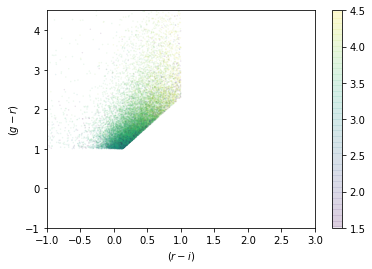

In [67]:
pl.scatter(ilim_gdrops['r'] - ilim_gdrops['i'], ilim_gdrops['g'] - ilim_gdrops['r'], marker='.', c=ilim_gdrops['Z_BEST'], alpha=0.1, label='', vmin=zmax, vmax=4.5, s=1)

pl.xlim(-1., 3.0)
pl.ylim(-1., 4.5)

pl.xlabel(r'$(r-i)$')
pl.ylabel(r'$(g-r)$')

pl.colorbar()

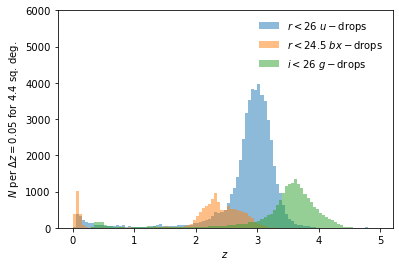

In [68]:
dz   = 0.05
bins = np.arange(0.0, 5.0, dz)

pl.hist(rlim_udrops['Z_BEST'], bins=bins, alpha=0.5, label=r'$r<26$ $u-$drops')
pl.hist(bx_clauds['Z_BEST'], bins=bins, alpha=0.5, label=r'$r<24.5$ $bx-$drops')
pl.hist(ilim_gdrops['Z_BEST'], bins=bins, alpha=0.5, label=r'$i<26 \ g-$drops')

pl.ylim(0.0, 6.e3)

pl.xlabel(r'$z$')
pl.ylabel(r'$N$ per $\Delta z={:.2f}$ for {:.1f} sq. deg.'.format(dz, area['u']))

pl.legend(frameon=False)

In [70]:
print('Target density of g-dropouts per sq. deg. is {:.2f}'.format(len(ilim_gdrops) / area['g']))

Target density of g-dropouts per sq. deg. is 2534.95


In [71]:
print('g-drop interloper percentage of {:.3f}'.format(100. * np.count_nonzero(ilim_gdrops['Z_BEST'] < 1.0) / len(ilim_gdrops)))

g-drop interloper percentage of 3.849


In [72]:
start_id = 1 + bxtiers['TARGETID'].max()
start_id

57354

21.7 	 1 	 259
21.7 	 1 	 259

23.6 	 2 	 1026	Adjusting 26 entries.
23.6 	 3 	 1000

24.3 	 4 	 3128	Adjusting 2128 entries.
24.3 	 5 	 1000

24.6 	 6 	 3038	Adjusting 2038 entries.
24.6 	 7 	 1000

24.8 	 8 	 2377	Adjusting 1377 entries.
24.8 	 9 	 1000

25.0 	 10 	 2006	Adjusting 1006 entries.
25.0 	 11 	 1000

25.1 	 12 	 1405	Adjusting 405 entries.
25.1 	 13 	 1000

25.2 	 14 	 1036	Adjusting 36 entries.
25.2 	 15 	 1000

25.3 	 16 	 725
25.3 	 16 	 725

25.4 	 17 	 578
25.4 	 17 	 578

25.5 	 18 	 584
25.5 	 18 	 584

25.6 	 19 	 369
25.6 	 19 	 369

25.7 	 20 	 344
25.7 	 20 	 344

25.7 	 21 	 91
25.7 	 21 	 91

25.8 	 22 	 280
25.8 	 22 	 280


-------------------------

17246 	 19874



     15000 	  33.0 per sq. deg. 	 18.04 	 23.53 	 2.75 	 (0.78 	 3.54 	 3.77) 	 29.34% z < 1.5 contamination
     14000 	  127.6 per sq. deg. 	 22.30 	 24.59 	 3.15 	 (3.36 	 3.61 	 3.81) 	 12.10% z < 1.5 contamination
     13000 	  127.6 per sq. deg. 	 23.75 	 25.01 	 3.34 	 (3.41 	 3.60 	 3.8

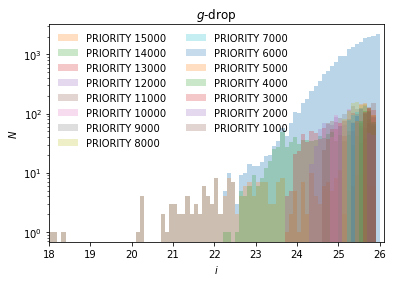

In [74]:
gtiers = reduce(start_id, ilim_gdrops, 'i', 'g', area['g'], max_inpriority=1000, priority_shift=0, maglim=26.01, reprioritise=False, levels=15, debug=False, write=False)

In [75]:
len(gtiers[gtiers['PRIORITY'] >= 0])

10230

In [ ]:
for tiers, ttype in zip([utiers, bxtiers, gtiers], ['u', 'bx', 'g']):
    Path('/global/cscratch1/sd/mjwilson/DESILBG/Feb21/targets/{}drops/'.format(ttype)).mkdir(parents=True, exist_ok=True)
        
    upriorities = np.unique(tiers['PRIORITY'])
        
    for up in upriorities:
        ptiers  = tiers[tiers['PRIORITY'] == up] 
        ptiers.write('/global/cscratch1/sd/mjwilson/DESILBG/Feb21/targets/{}drops/{}drops-{}.fits'.format(ttype, ttype, str(up).replace('-','m')), format='fits', overwrite=True)

Text(0.5, 1.0, 'Clauds COSMOS: (150.1370, 2.2022)')

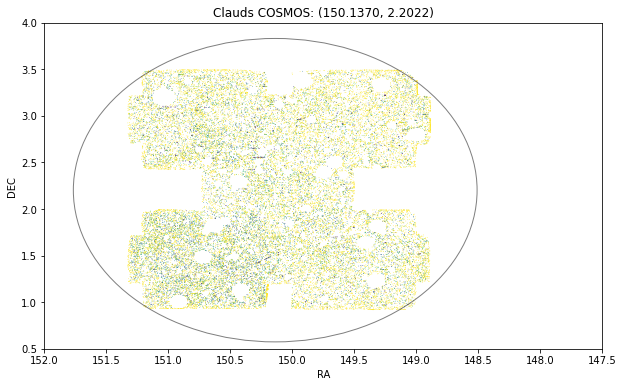

In [74]:
fig, ax  = plt.subplots(1, 1, figsize=(10, 6)) 
im       = pl.scatter(utiers['RA'], utiers['DEC'], c=utiers['u_err'], marker='.', s=2, lw=0.0, vmin=0.0, vmax=.25)

for ind in tileids:    
    circles(cra, cdec, trad, c='k', fc="None", alpha=0.5)
    
    break
    
ax.set_xlim(152., 147.5)
ax.set_ylim( 0.5,   4.0)

ax.set_xlabel('RA')
ax.set_ylabel('DEC')

# cax      = fig.add_axes([0.15, 0.2, 0.2, 0.05])
# fig.colorbar(im, cax=cax, orientation='horizontal')

ax.set_title('Clauds COSMOS: ({:.4f}, {:.4f})'.format(cra, cdec))

In [ ]:
fig, ax  = plt.subplots(1, 1, figsize=(10, 6)) 
im       = pl.scatter(bxtiers['RA'], bxtiers['DEC'], c=bxtiers['u_err'], marker='.', s=2, lw=0.0, vmin=0.0, vmax=.25)

for ind in tileids:    
    circles(cra, cdec, trad, c='k', fc="None", alpha=0.5)
    
    break
    
ax.set_xlim(152., 147.5)
ax.set_ylim( 0.5,   4.0)

ax.set_xlabel('RA')
ax.set_ylabel('DEC')

ax.set_title('Clauds COSMOS: ({:.4f}, {:.4f})'.format(cra, cdec))

Text(0.5, 1.0, 'Clauds COSMOS: (150.1370, 2.2022)')

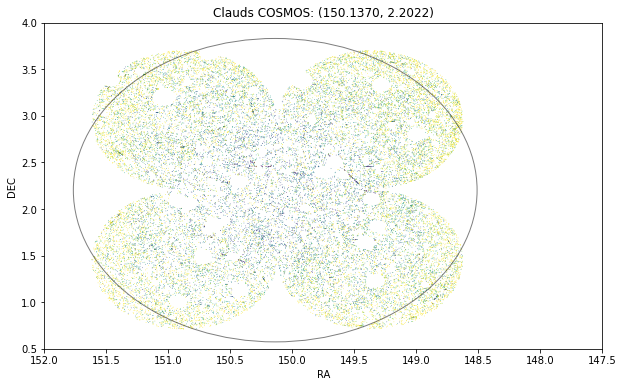

In [76]:
fig, ax  = plt.subplots(1, 1, figsize=(10, 6)) 
im       = pl.scatter(gtiers['RA'], gtiers['DEC'], c=gtiers['g_err'], marker='.', s=2, lw=0.0, vmin=0.0, vmax=.25)

for ind in tileids:    
    circles(cra, cdec, trad, c='k', fc="None", alpha=0.5)
    
    break
    
ax.set_xlim(152., 147.5)
ax.set_ylim( 0.5,   4.0)

ax.set_xlabel('RA')
ax.set_ylabel('DEC')

ax.set_title('Clauds COSMOS: ({:.4f}, {:.4f})'.format(cra, cdec))

# Done.